In [1]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import FuncFormatter
import numpy as np
import pickle
import math
import networkx as nx
import warnings
from pathlib import Path
import xlrd
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.sans-serif'] = ['Helvetica']

### Reading in data & joining

In [2]:
sponsors115= pd.read_excel("./data/115-Sponsors.xlsx")
bills115= pd.read_excel("./data/115-Bills.xlsx")

sponsors114= pd.read_excel("./data/114-Sponsors.xlsx")
bills114= pd.read_excel("./data/114-Bills.xlsx")

sponsors113= pd.read_excel("./data/113-Sponsors.xlsx")
bills113= pd.read_excel("./data/113-Bills.xlsx")

sponsors112= pd.read_excel("./data/112-Sponsors.xlsx")
bills112= pd.read_excel("./data/112-Bills.xlsx")

sponsors111= pd.read_excel("./data/111-Sponsors.xlsx")
bills111= pd.read_excel("./data/111-Bills.xlsx")

icspr = pd.read_csv("./data/bioguide_icpsr_crosswalk.csv")

In [3]:
house_committee = pd.read_excel("./data/house_assignments_103-115-3.xls")
senate_committee = pd.read_excel("./data/senate_assignments_103-115-3.xls")

 **Add bioguide id to Congresses before 113**

In [4]:
# bioguide ids for old members
old = pd.read_csv("./data/legislators-historical.csv")
current = pd.read_csv("./data/legislators-current.csv")

In [5]:
congress_members = pd.concat([old, current])
congress_members_short = congress_members[["thomas_id", "bioguide_id"]]

In [6]:
thomas_id_only = pd.concat([sponsors111, sponsors112])

In [7]:
sponsors_old_bio=thomas_id_only.merge(congress_members_short, left_on="thomas_id", right_on="thomas_id",how="left")

In [8]:
sponsors_old_bio=sponsors_old_bio.drop(["bioguide_id_x"], axis=1)
sponsors_old_bio=sponsors_old_bio.rename({"bioguide_id_y":"bioguide_id"},axis=1)

In [9]:
thomas_id_only_bills = pd.concat([bills111, bills112])
bills_old_bio=thomas_id_only_bills.merge(congress_members_short, left_on="thomas_id", right_on="thomas_id",how="left")

In [10]:
bills_old_bio=bills_old_bio.drop(["bioguide_id_x"], axis=1)
bills_old_bio=bills_old_bio.rename({"bioguide_id_y":"bioguide_id"},axis=1)

### Cleaning

**Concat the sponsors datasets (one with bioguide, one with thomas)**

In [11]:
sponsors_new = pd.concat([sponsors115, sponsors114, sponsors113])
sponsors_new

,bill_id,bioguide_id,thomas_id,primary_sponsor,name,state,introduced_at,congress,bill_type
0,hjres144-115,M001200,NaN,True,"McEachin, A. Donald",VA,2018-12-11,115,hjres
1,hjres144-115,B001300,NaN,False,"Barragan, Nanette Diaz",CA,2018-12-11,115,hjres
2,hjres144-115,J000298,NaN,False,"Jayapal, Pramila",WA,2018-12-11,115,hjres
3,hjres143-115,F000372,NaN,True,"Frelinghuysen, Rodney P.",NJ,2018-12-03,115,hjres
4,hjres126-115,Y000062,NaN,True,"Yarmuth, John A.",KY,2018-01-19,115,hjres
...,...,...,...,...,...,...,...,...,...
152546,sjres15-113,W000779,NaN,False,"Wyden, Ron",OR,2013-05-09,113,sjres
152547,sjres23-113,C001098,NaN,True,"Cruz, Ted",TX,2013-10-02,113,sjres
152548,sjres24-113,C000127,NaN,True,"Cantwell, Maria",WA,2013-10-10,113,sjres
152549,sjres24-113,B001265,NaN,False,"Begich, Mark",AK,2013-10-10,113,sjres


In [12]:
sponsors_old_bio = sponsors_old_bio[['bill_id', 'bioguide_id', 'thomas_id', 'primary_sponsor', 'name', 'state', 'introduced_at', 'congress', 'bill_type']]
sponsors_old_bio

,bill_id,bioguide_id,thomas_id,primary_sponsor,name,state,introduced_at,congress,bill_type
0,hconres1-111,S000480,1069.0,True,"Slaughter, Louise McIntosh",NY,2009-01-06,111,hconres
1,hconres10-111,J000032,588.0,True,"Jackson-Lee, Sheila",TX,2009-01-07,111,hconres
2,hconres100-111,B001230,1558.0,True,"Baldwin, Tammy",WI,2009-04-21,111,hconres
3,hconres100-111,B001149,154.0,False,"Burton, Dan",IN,2009-04-21,111,hconres
4,hconres100-111,C001062,1805.0,False,"Conaway, K. Michael",TX,2009-04-21,111,hconres
...,...,...,...,...,...,...,...,...,...
349368,sres99-112,R000595,2084.0,False,"Rubio, Marco",FL,2011-03-10,112,sres
349369,sres99-112,S001141,1548.0,False,"Sessions, Jeff",AL,2011-03-10,112,sres
349370,sres99-112,T000250,1534.0,False,"Thune, John",SD,2011-03-10,112,sres
349371,sres99-112,V000127,1609.0,False,"Vitter, David",LA,2011-03-10,112,sres


In [13]:
# Concat
sponsors = pd.concat([sponsors_new, sponsors_old_bio])
sponsors.head()

,bill_id,bioguide_id,thomas_id,primary_sponsor,name,state,introduced_at,congress,bill_type
0,hjres144-115,M001200,NaN,True,"McEachin, A. Donald",VA,2018-12-11,115,hjres
1,hjres144-115,B001300,NaN,False,"Barragan, Nanette Diaz",CA,2018-12-11,115,hjres
2,hjres144-115,J000298,NaN,False,"Jayapal, Pramila",WA,2018-12-11,115,hjres
3,hjres143-115,F000372,NaN,True,"Frelinghuysen, Rodney P.",NJ,2018-12-03,115,hjres
4,hjres126-115,Y000062,NaN,True,"Yarmuth, John A.",KY,2018-01-19,115,hjres


In [14]:
bills_new = pd.concat([bills115, bills114, bills113])
bills_new.head()

,bill_id,subjects_top_term,status,updated_at,status_at,introduced_at,bill_type,congress,number,thomas_id,bioguide_id,awaiting_signature,enacted,vetoed,active,house_passage_result,senate_passage_result,subjects,committees
0,hjres144-115,Environmental protection,REFERRED,2019-04-18T15:56:48Z,2018-12-11,2018-12-11,hjres,115,144,NaN,M001200,False,False,False,False,NaN,NaN,"['Air quality', 'Constitution and constitution...",['House Judiciary']
1,hjres143-115,Economics and public finance,ENACTED:SIGNED,2019-11-15T20:51:47Z,2018-12-07,2018-12-03,hjres,115,143,NaN,F000372,False,True,False,True,pass,pass,"['Appropriations', 'Crimes against women', 'Di...",['House Appropriations']
2,hjres126-115,Government operations and politics,REFERRED,2019-11-15T21:34:19Z,2018-01-19,2018-01-19,hjres,115,126,NaN,Y000062,False,False,False,False,NaN,NaN,"['Constitution and constitutional amendments',...","['House Judiciary', 'House Judiciary']"
3,hjres119-115,Economics and public finance,REFERRED,2019-11-15T21:34:24Z,2017-10-23,2017-10-23,hjres,115,119,NaN,B001290,False,False,False,False,NaN,NaN,"['Budget deficits and national debt', 'Constit...","['House Judiciary', 'House Judiciary']"
4,hjres121-115,Families,REFERRED,2019-11-15T21:34:25Z,2017-11-16,2017-11-16,hjres,115,121,NaN,H001059,False,False,False,False,NaN,NaN,"['Child care and development', 'Constitution a...","['House Judiciary', 'House Judiciary']"


In [15]:
bills_old_bio = bills_old_bio[["bill_id", "subjects_top_term", "status", "updated_at", "status_at", "introduced_at", "bill_type", "congress", "number", "thomas_id", "bioguide_id", "awaiting_signature", "enacted", "vetoed", "active", "house_passage_result", "senate_passage_result", "subjects", "committees"]]

In [16]:
# Concat
bills = pd.concat([bills_old_bio, bills113, bills114, bills115])

In [17]:
# Find percentage of bills that are hr or s
len(bills[(bills["bill_type"] == "hr") | (bills["bill_type"] == "s")]) / len(bills)

0.7045307665864559

In [18]:
all_sponsors = sponsors[(sponsors["bill_type"] == "hr") | (sponsors["bill_type"]=="s")]
all_bills = bills[(bills["bill_type"] == "hr") | (bills["bill_type"] == "s")]


**Merge data to match bioguide & icpsr & committee data**

In [19]:
icspr.drop("Unnamed: 0",inplace=True, axis=1)
bills_merge = icspr.merge(all_bills, left_on='bioguide_id', right_on='bioguide_id', how="right")
bills_merge.shape

(51237, 20)

In [20]:
hr_bills=bills_merge[bills_merge["bill_type"]=="hr"]
senate_bills=bills_merge[bills_merge["bill_type"]=="s"]

**Choose chamber of interest**

In [21]:
# investigate na
na_icpsr = bills_merge[bills_merge['icpsr_id'].isna()]
na_icpsr["bioguide_id"].unique()

array(['N000147', 'B001245', 'P000596', 'F000010', nan, 'C000380',
       'S001177', 'P000610', 'R000600', 'G000582'], dtype=object)

In [22]:
# sponsors
all_sponsors=icspr.merge(all_sponsors, left_on='bioguide_id', right_on='bioguide_id', how="right")

house_sponsors = all_sponsors[(all_sponsors["bill_type"] == "hr")]
senate_sponsors = all_sponsors[(all_sponsors["bill_type"] == "s")]

In [23]:
house_sponsors.size

5566340

In [24]:
# committee
house_committee_df = house_committee[house_committee['Congress'].isin([111.0,112.0,113.0, 114.0, 115.0])]
senate_committee_df = senate_committee[senate_committee['Congress'].isin([111.0,112.0,113.0, 114.0, 115.0])]

In [25]:
house_committee_df.columns

Index(['Congress', 'Committee code', 'ID #', 'Name', 'Maj/Min',
       'Rank Within Party Status', 'Party', 'Date of Assignment',
       'Date of Termination', 'Senior Party Member', 'Committee Seniority',
       'Committee Period of Service',
       'Committee status at end of this Congress',
       'Committee continuity of assignment in next Congress',
       'Appointment Citation', 'Committee Name', 'State', 'CD', 'State Name',
       'Notes'],
      dtype='object')

In [26]:
senate_committee_df.rename({"Party Code":"Party"},axis=1,inplace=True)

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_9108/3906259456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senate_committee_df.rename({"Party Code":"Party"},axis=1,inplace=True)


In [27]:
senate_committee_df.columns

Index(['Congress', 'Committee Code', 'ID #', 'Name', 'Maj/Min',
       'Rank Within Party', 'Party', 'Date of Appointment',
       'Date of Termination', 'Unnamed: 9', 'Senior Party Member',
       'Committee Seniority', 'Committee Period of Service',
       'Committee status at end of this Congress',
       'Committee continuity of assignment in next Congress',
       'Appointment Citation', 'Committee Name', 'State Code', 'District',
       'State Name', 'Notes'],
      dtype='object')

In [28]:
# clean committee data on both bill sets
hr_bills['committees'] = hr_bills['committees'].str.replace("\[", "")
hr_bills['committees'] = hr_bills['committees'].str.replace("\]", "")

hr_commit_list = hr_bills["committees"]
hr_bills=pd.concat([hr_bills, hr_commit_list.str.split(', ', expand=True)], axis=1)

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_9108/230096830.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  hr_bills['committees'] = hr_bills['committees'].str.replace("\[", "")
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_9108/230096830.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hr_bills['committees'] = hr_bills['committees'].str.replace("\[", "")
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_9108/230096830.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  hr_bills['committees'] = hr_bills['committees'].str.replace("\]", "")
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_9108/2300

In [29]:
# clean committee data on both bill sets
senate_bills['committees'] = senate_bills['committees'].str.replace("\[", "")
senate_bills['committees'] = senate_bills['committees'].str.replace("\]", "")

senate_commit_list = senate_bills["committees"]
senate_bills=pd.concat([senate_bills, senate_commit_list.str.split(', ', expand=True)], axis=1)

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_9108/2594445457.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  senate_bills['committees'] = senate_bills['committees'].str.replace("\[", "")
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_9108/2594445457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senate_bills['committees'] = senate_bills['committees'].str.replace("\[", "")
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_9108/2594445457.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  senate_bills['committees'] = senate_bills['committees'].str.replace("\]", "")
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0

In [30]:
senate_bills.columns

Index([          'bioguide_id',              'icpsr_id',
                     'bill_id',     'subjects_top_term',
                      'status',            'updated_at',
                   'status_at',         'introduced_at',
                   'bill_type',              'congress',
                      'number',             'thomas_id',
          'awaiting_signature',               'enacted',
                      'vetoed',                'active',
        'house_passage_result', 'senate_passage_result',
                    'subjects',            'committees',
                             0,                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10,                      11,
                            12],
      dtype='object')

### Cosponsorship rates

In [31]:
# Max cosponsor analysis for the House
cosponsor_count=house_sponsors[house_sponsors["primary_sponsor"] ==False].groupby(["congress","icpsr_id"])["bill_id"].nunique().reset_index(name='Count')
cosponsor_count.head()

,congress,icpsr_id,Count
0,111,2605.0,149
1,111,10713.0,468
2,111,12036.0,30
3,111,13035.0,272
4,111,13047.0,152


In [32]:
threshold = np.percentile(cosponsor_count["Count"], 90)

# Filter the dataset to keep only the numbers greater than the threshold
high_cosponsors = cosponsor_count[cosponsor_count["Count"] > threshold]
high_cosponsors=high_cosponsors.sort_values("Count", ascending=False)

In [33]:
total_bill_count = hr_bills.groupby("congress")["bill_id"].size()

In [34]:
total_bill_count=total_bill_count.reset_index().rename(columns={"bill_id":"bill_count"})

In [35]:
total_bill_count

,congress,bill_count
0,111,6562
1,112,6723
2,113,5885
3,114,6526
4,115,7394


In [36]:
high_cosponsors

,congress,icpsr_id,Count
107,111,20305.0,797
1864,115,20748.0,791
2185,115,29729.0,744
322,111,29325.0,734
1373,114,20305.0,695
...,...,...,...
370,111,29585.0,380
1437,114,20733.0,380
2155,115,29317.0,380
1566,114,21309.0,380


In [37]:
max_cosponsors=high_cosponsors.groupby("congress")["Count"].max()

In [38]:
max_cosponsors_by_congress = pd.merge(max_cosponsors, total_bill_count, on="congress")
max_cosponsors_by_congress["max_cosponsors_per_bill_count"] = max_cosponsors_by_congress["Count"] / max_cosponsors_by_congress["bill_count"]
max_cosponsors_by_congress

,congress,Count,bill_count,max_cosponsors_per_bill_count
0,111,797,6562,0.121457
1,112,632,6723,0.094006
2,113,666,5885,0.113169
3,114,695,6526,0.106497
4,115,791,7394,0.106979


In [40]:
# Max cosponsor analysis for the Senate
cosponsor_count_senate=senate_sponsors[senate_sponsors["primary_sponsor"] ==False].groupby(["congress","icpsr_id"])["bill_id"].nunique().reset_index(name='Count')
cosponsor_count_senate.head()

,congress,icpsr_id,Count
0,111,1366.0,64
1,111,4812.0,145
2,111,10808.0,123
3,111,14009.0,144
4,111,14203.0,77


In [41]:
threshold_senate = np.percentile(cosponsor_count_senate["Count"], 90)

# Filter the dataset to keep only the numbers greater than the threshold
high_cosponsors_senate = cosponsor_count_senate[cosponsor_count_senate["Count"] > threshold_senate]
high_cosponsors_senate=high_cosponsors_senate.sort_values("Count", ascending=False)

In [42]:
total_bill_count_senate = senate_bills.groupby("congress")["bill_id"].size()

In [43]:
total_bill_count_senate=total_bill_count_senate.reset_index().rename(columns={"bill_id":"bill_count"})

In [44]:
max_cosponsors_senate=high_cosponsors_senate.groupby("congress")["Count"].max()

In [45]:
max_cosponsors_by_congress_senate = pd.merge(max_cosponsors_senate, total_bill_count_senate, on="congress")
max_cosponsors_by_congress_senate["max_cosponsors_per_bill_count"] = max_cosponsors_by_congress_senate["Count"] / max_cosponsors_by_congress_senate["bill_count"]
max_cosponsors_by_congress_senate

,congress,Count,bill_count,max_cosponsors_per_bill_count
0,111,377,4059,0.092880
1,112,346,3716,0.093111
2,113,362,3019,0.119907
3,114,373,3548,0.105130
4,115,520,3805,0.136662


In [51]:
bills["bill_type"].value_counts().sum()

72725

In [52]:
bills["bill_type"].value_counts()

hr         33090
s          18147
hjres      11111
hres        5557
sres        3327
hconres      940
sconres      304
sjres        249
Name: bill_type, dtype: int64

In [55]:
(33090+18147)/72725

0.7045307665864559

### Length of Time for Bill Passage

In [40]:
pass_house_bills = hr_bills[hr_bills["status"]=="PASS_OVER:HOUSE"]
pass_house_bills['introduced_at'] = pd.to_datetime(pass_house_bills['introduced_at'], errors='coerce', utc=True)
pass_house_bills['status_at'] = pd.to_datetime(pass_house_bills['status_at'], errors='coerce', utc=True)

pass_house_bills['time_to_pass_house_chamber'] = (pass_house_bills['status_at'] - pass_house_bills['introduced_at']).dt.days

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/979432227.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_house_bills['introduced_at'] = pd.to_datetime(pass_house_bills['introduced_at'], errors='coerce', utc=True)
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/979432227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_house_bills['status_at'] = pd.to_datetime(pass_house_bills['status_at'], errors='coerce', utc=True)
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w

In [41]:
pass_house_bills["time_to_pass_house_chamber"].median()

98.0

In [42]:
pass_house_bills["time_to_pass_house_chamber"].mean()

148.3164770332912

In [43]:
pass_senate_bills = senate_bills[senate_bills["status"]=="PASS_OVER:SENATE"]
pass_senate_bills['introduced_at'] = pd.to_datetime(pass_senate_bills['introduced_at'], errors='coerce', utc=True)
pass_senate_bills['status_at'] = pd.to_datetime(pass_senate_bills['status_at'], errors='coerce', utc=True)

pass_senate_bills['time_to_pass_senate_chamber'] = (pass_senate_bills['status_at'] - pass_senate_bills['introduced_at']).dt.days

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/1450161812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_senate_bills['introduced_at'] = pd.to_datetime(pass_senate_bills['introduced_at'], errors='coerce', utc=True)
/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/1450161812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_senate_bills['status_at'] = pd.to_datetime(pass_senate_bills['status_at'], errors='coerce', utc=True)
/var/folders/ym/ph5q_6vn3fl5hj4x_h

In [44]:
pass_senate_bills["time_to_pass_senate_chamber"].median()

148.0

In [45]:
pass_senate_bills["time_to_pass_senate_chamber"].mean()

195.7358024691358

### Basic Statistics

In [46]:
# Pass house rate

house_care_1=["PASS_OVER:HOUSE", "ENACTED:SIGNED", "PASS_BACK:SENATE", "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE", "PROV_KILL:CLOTUREFAILED", "PROV_KILL:VETO", "ENACTED:TENDAYRULE", "CONFERENCE:PASSED:HOUSE"]

total_bills_per_congress = hr_bills.groupby('congress').size()

(hr_bills[hr_bills['status'].isin(house_care_1)].groupby('congress').size()) / total_bills_per_congress

congress
111    0.109875
112    0.073033
113    0.098726
114    0.118449
115    0.134974
dtype: float64

In [47]:
# Pass everything rate

enacted_1=["ENACTED:SIGNED", "ENACTED:TENDAYRULE"]

(hr_bills[hr_bills['status'].isin(enacted_1)].groupby('congress').size())/total_bills_per_congress

congress
111    0.038708
112    0.029600
113    0.035514
114    0.033098
115    0.038410
dtype: float64

In [48]:
# Mean # of cosponsors per bill
bills_per_congress = house_sponsors[house_sponsors["primary_sponsor"] ==False].groupby(["congress","bill_id"])["icpsr_id"].nunique().reset_index()
bills_per_congress.groupby("congress").mean()

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/3516300295.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bills_per_congress.groupby("congress").mean()


,icpsr_id
congress,
111,21.503596
112,21.437825
113,21.956999
114,20.932604
115,19.077407


In [49]:
# Max # of cosponsors per bill
bills_per_congress.groupby("congress").max()

,bill_id,icpsr_id
congress,,
111,hr999-111,418
112,hr999-112,424
113,hr999-113,378
114,hr999-114,331
115,hr999-115,380


In [50]:
# Mean # of bills per cosponsor
bills_per_cosponsor = house_sponsors[house_sponsors["primary_sponsor"] ==False].groupby(["congress","icpsr_id"])["bill_id"].nunique().reset_index()
bills_per_cosponsor.groupby("congress")["bill_id"].mean()

congress
111    235.716216
112    205.628118
113    227.454545
114    243.531818
115    250.865772
Name: bill_id, dtype: float64

In [51]:
# Max # of bills per cosponsor
bills_per_cosponsor.groupby("congress")["bill_id"].max()

congress
111    797
112    632
113    666
114    695
115    791
Name: bill_id, dtype: int64

### Dictionaries

In [52]:
# key is name, value is index
def icpsr_index_dict(unique_sponsors):
		icpsr_to_index = {} # key
		index_to_icpsr = {} # reversed_key
		for i, icpsr in zip(range(len(unique_sponsors)), unique_sponsors):
				icpsr_to_index[icpsr] = i
				index_to_icpsr[i] = icpsr
		return icpsr_to_index, index_to_icpsr

In [53]:
def id_party_dict(chamber, icpsr_to_index):
	if chamber == "house":
		committee = house_committee_df
	else:
		committee = senate_committee_df
	id_to_party = {}
	for cosponsor_id in list(icpsr_to_index.keys()):
			party = committee[committee['ID #'] == cosponsor_id]['Party']
			if len(party) < 1: continue
			id_to_party[cosponsor_id] = "Rep" if list(party)[0] == 200 else "Dem"
	return id_to_party

In [54]:
def congress_party_dict(unique_congress, chamber):
	if chamber == "house":
		committee = house_committee_df
	else:
		committee = senate_committee_df

	congress_party_dict = {}

	for congress_num in unique_congress:
		committee_now = committee[committee["Congress"] == congress_num]
		df = committee_now.drop_duplicates('ID #')
		dem_count = len(df[df["Party"] == 100.0])
		rep_count = len(df[df["Party"] == 200.0])
		congress_party_dict[congress_num] = [dem_count, rep_count]
	return(congress_party_dict)

In [55]:
def congress_people_dict(chamber):
	if chamber == "house":
		sponsors = house_sponsors
	else:
		sponsors = senate_sponsors

	congress_people_dict = {}

	unique_congresses = sponsors["congress"].unique()
	unique_sponsors = sponsors["icpsr_id"].unique()
	icpsr_to_index, index_to_icpsr = icpsr_index_dict(unique_sponsors)

	for congress in unique_congresses:
		ids = sponsors[sponsors["congress"] == congress]["icpsr_id"].dropna().unique()
		congress_people_dict[congress] = [icpsr_to_index[id] for id in ids]

	return(congress_people_dict)

In [56]:
def congress_bill_topic_diff(chamber, carelist):
	if chamber == "house":
		bills = hr_bills
	else:
		bills = senate_bills

	unique_congresses = bills["congress"].unique()
	congress_bill_topic_diff_dict ={}

	bills_copy=bills.copy()
	bills_copy["pass_chamber"] = 0

	for index, row in bills_copy.iterrows():
		if row["status"] in carelist:
			bills_copy.loc[index, "pass_chamber"] = 1


	for congress in unique_congresses:
		bills_copy_specific_congress = bills_copy[bills_copy["congress"] == congress]

		grouped_data = bills_copy_specific_congress.groupby("subjects_top_term")["pass_chamber"].mean().reset_index()
		grouped_data = grouped_data.sort_values(by="pass_chamber", ascending=False)

		threshold_25 = grouped_data['pass_chamber'].quantile(0.25)
		threshold_50 = grouped_data["pass_chamber"].quantile(0.50)

		# filter data based on thresholds
		lowest_25_data = grouped_data[grouped_data['pass_chamber'] <= threshold_25]
		lowest_50_data = grouped_data[(grouped_data['pass_chamber'] > threshold_25) & (grouped_data['pass_chamber'] <= threshold_50)]

		bill_topics_lowest_25 = lowest_25_data['subjects_top_term'].tolist()
		bill_topics_26_to_50 = lowest_50_data['subjects_top_term'].tolist()

		# store in dictionary
		congress_bill_topic_diff_dict[congress] =	(bill_topics_lowest_25, bill_topics_26_to_50)

	return(congress_bill_topic_diff_dict)

In [57]:
care_senate_cham=["ENACTED:SIGNED", "PASS_OVER:SENATE", "PROV_KILL:CLOTUREFAILED", "PROV_KILL:SUSPENSIONFAILED", "PASS_BACK:HOUSE", "PASSED:BILL", "VETOED:OVERRIDE_FAIL_ORIGINATING:SENATE", "ENACTED:VETO_OVERRIDE"]
senate_cham_dict_topics = congress_bill_topic_diff("senate", care_senate_cham)

## Matrix Building

### Simple Adjacency Matrix

In [58]:
# carelist is a list of given statuses we care about
# chamber is house or senate
# normalized by total number of bills that passed in a given month
def build_co_adj_matrix(carelist, chamber):
	if chamber == "house":
		interest_bills = hr_bills
		caresponsors = house_sponsors
	else:
		interest_bills = senate_bills
		caresponsors = senate_sponsors

	unique_sponsors = caresponsors["icpsr_id"].unique()

	icpsr_to_index, index_to_icpsr = icpsr_index_dict(unique_sponsors)

	# any bill
	interest_bills_all = interest_bills
	interest_bills_all["introduced_at"] = pd.to_datetime(interest_bills_all["introduced_at"])

	adj_matrices =[]

	last_month = None
	for month in sorted(interest_bills_all["introduced_at"].dt.to_period("M").unique()):
		print(month)
		adj_matrix = np.zeros((len(unique_sponsors), len(unique_sponsors), 2))
		# Get this month's bills
		all_bills_month_df = interest_bills_all[interest_bills_all["introduced_at"].dt.to_period("M")==month]

		# Fill out matrix
		for bill,status in all_bills_month_df[["bill_id", "status"]].to_numpy():
			sponsors = list(caresponsors[caresponsors['bill_id'] == bill]['icpsr_id'])

			for i in range(len(sponsors)):
					for j in range(i+1, len(sponsors)):
							id_1, id_2 = sponsors[i], sponsors[j]
							if np.isnan(id_1) or np.isnan(id_2): continue
							# fill out denominator array
							if status in carelist:
								adj_matrix[icpsr_to_index[id_1], icpsr_to_index[id_2]] += 1
								adj_matrix[icpsr_to_index[id_2], icpsr_to_index[id_1]] += 1
							else: #just add to denominator
								adj_matrix[icpsr_to_index[id_1], icpsr_to_index[id_2], 1] += 1
								adj_matrix[icpsr_to_index[id_2], icpsr_to_index[id_1], 1] += 1

		if last_month != None:
			while (last_month +1 != month):
					adj_matrices.append(np.zeros((len(unique_sponsors), len(unique_sponsors), 2)))
					last_month += 1
		last_month = month
		adj_matrices.append(adj_matrix)

	adj_matrices = np.array(adj_matrices)
	return adj_matrices

In [59]:
# carelist is a list of given statuses we care about
# chamber is house or senate
# normalized by total number of bills that passed in a given month
def build_norm_adj_matrix(carelist, chamber):
	if chamber == "house":
		interest_bills = hr_bills
		caresponsors = house_sponsors
	else:
		interest_bills = senate_bills
		caresponsors = senate_sponsors

	unique_sponsors = caresponsors["icpsr_id"].unique()

	icpsr_to_index, index_to_icpsr = icpsr_index_dict(unique_sponsors)

	interest_bills = interest_bills[interest_bills['status'].isin(carelist)]
	interest_bills["introduced_at"] = pd.to_datetime(interest_bills["introduced_at"])

	adj_matrices =[]

	last_month = None
	for month in sorted(interest_bills["introduced_at"].dt.to_period("M").unique()):
		print(month)
		adj_matrix = np.zeros((len(unique_sponsors), len(unique_sponsors), 2))
		# Get this month's bills
		bills_month_df = interest_bills[interest_bills['introduced_at'].dt.to_period('M') == month]
		bills = bills_month_df['bill_id'].unique()

		# Fill out matrix
		for bill in bills:
				sponsors = list(caresponsors[caresponsors['bill_id'] == bill]['icpsr_id'])
				for i in range(len(sponsors)):
						for j in range(i+1, len(sponsors)):
								id_1, id_2 = sponsors[i], sponsors[j]
								if np.isnan(id_1) or np.isnan(id_2): continue
								# fill out numerator array
								adj_matrix[icpsr_to_index[id_1], icpsr_to_index[id_2], 0] += 1
								adj_matrix[icpsr_to_index[id_2], icpsr_to_index[id_1], 0] += 1

		adj_matrix[:,:,1] = len(bills)

		if last_month != None:
			while (last_month +1 != month):
					adj_matrices.append(np.zeros((len(unique_sponsors), len(unique_sponsors), 2)))
					last_month += 1
		last_month = month
		adj_matrices.append(adj_matrix)

	adj_matrices = np.array(adj_matrices)
	return adj_matrices

### Cumulative Adj Matrix with Decay

In [60]:
# where halflife is halflife in months
# where amount is months passed
def decay(amount, half_life):
		k = (math.log(0.5))/half_life
		assert k < 0
		d = np.exp(amount * k)
		assert d > 0.0 and d < 1.0
		return d


def create_cumulative_adj_matrix(adj_matrices, half_life):
		cum_adj_matrices = np.zeros_like(adj_matrices)

		for i in range(len(adj_matrices)):
				for j in range(0, i):
						# adding decayed numerator
						cum_adj_matrices[i, :, :, 0] += adj_matrices[j, :, :, 0] * decay(i - j, half_life)
						# adding denominator
						cum_adj_matrices[i, :, :, 1] += adj_matrices[j, :, :, 1] * decay(i - j, half_life)

				cum_adj_matrices[i] += adj_matrices[i]
		return (cum_adj_matrices)

### Party Influence

In [61]:
def create_party_inf_matrix(cum_adj_matrices, chamber):
	if chamber == "house":
		interest_bills = hr_bills
		caresponsors = house_sponsors
	else:
		interest_bills = senate_bills
		caresponsors = senate_sponsors

	unique_sponsors = caresponsors["icpsr_id"].unique()

	icpsr_to_index, index_to_icpsr = icpsr_index_dict(unique_sponsors)

	id_to_party = id_party_dict(chamber, icpsr_to_index)

	party_influence = np.zeros((len(cum_adj_matrices), len(unique_sponsors), 2))

	for month_index in range(len(cum_adj_matrices)):
		adj_month = cum_adj_matrices[month_index]
		for cosponsor in range(len(adj_month)):
			dem_num = 0
			dem_den = 0
			rep_num = 0
			rep_den = 0
			for i in range(len(adj_month[cosponsor])):
				# if the cosponsor they are attached to is a dem
				if id_to_party.get(index_to_icpsr.get(i)) == "Dem":
					dem_num += adj_month[cosponsor, i, 0]
					dem_den += adj_month[cosponsor, i, 1]
				else:
					rep_num += adj_month[cosponsor, i, 0]
					rep_den += adj_month[cosponsor, i, 1]
			# sum nums, dems separately, then divide
			if dem_den !=0:
				party_influence[month_index, cosponsor, 0] = (dem_num/dem_den)
			elif dem_den == 0:
				party_influence[month_index, cosponsor, 0] = 0
			if rep_den !=0:
				party_influence[month_index, cosponsor, 1] = (rep_num/rep_den)
			elif rep_den == 0:
				party_influence[month_index, cosponsor, 1] = 0

	# normalize by # of people in each party in each congress
	unique_congress = interest_bills["congress"].unique()
	num_congress=len(unique_congress)
	congress_to_party_amt = congress_party_dict(unique_congress, "house")
	ordered_congress = sorted(congress_to_party_amt.keys())

	for month_index in range(len(party_influence)):

		div = congress_to_party_amt[ordered_congress[month_index//24]]
		party_influence[month_index] = party_influence[month_index]/div

	return(party_influence)

## Influence by Bill Level

In [62]:
def influence_by_bill(start_date, influence_matrix, chamber, carelist, normalize_cosponsor=True):
	mat_list = []

	if chamber == "house":
		interest_bills = hr_bills
		caresponsors = house_sponsors
	else:
		interest_bills = senate_bills
		caresponsors = senate_sponsors

	unique_sponsors = caresponsors["icpsr_id"].unique()
	icpsr_to_index, index_to_icpsr = icpsr_index_dict(unique_sponsors)

	start = pd.Period(start_date)

	# for every bill in the bill list
	for bill_index in range(len(interest_bills)):
		if (bill_index%1000 == 0): print(bill_index)

		bill_id = interest_bills["bill_id"].iloc[bill_index]

		# keep track of bill status
		passed = 1 if (interest_bills[interest_bills['bill_id'] == bill_id]['status'].isin(carelist)).item() else 0

		# the month we care about influence for
		intro_month = interest_bills["introduced_at"].dt.to_period("M").iloc[bill_index]
		month_index = (intro_month - start).n

		if month_index >= influence_matrix.shape[0]:
			continue

		inf_score = 0
		bill_id = interest_bills["bill_id"].iloc[bill_index]

		cosponsor_list = caresponsors[caresponsors["bill_id"] == bill_id]["icpsr_id"].unique()
		cosponsor_num = len(cosponsor_list)

		for cosponsor in cosponsor_list:
			if np.isnan(cosponsor) or np.isnan(icpsr_to_index[cosponsor]):
				continue
			cosponsor_index = icpsr_to_index[cosponsor]
			inf_score += influence_matrix[month_index, cosponsor_index]
		if normalize_cosponsor:
			inf_score = inf_score/cosponsor_num

		mat_list.append([bill_id, inf_score, intro_month, passed])

	mat_bill_inf = np.array(mat_list)
	mat_bill_inf=pd.DataFrame(mat_bill_inf, columns=["Bill_ID", "Influence_Score", "Time", "Passed"])
	return(mat_bill_inf)

In [63]:
def max_influence_by_bill(start_date, influence_matrix, chamber, carelist):
	mat_list = []

	if chamber == "house":
		interest_bills = hr_bills
		caresponsors = house_sponsors
	else:
		interest_bills = senate_bills
		caresponsors = senate_sponsors

	unique_sponsors = caresponsors["icpsr_id"].unique()
	icpsr_to_index, index_to_icpsr = icpsr_index_dict(unique_sponsors)

	start = pd.Period(start_date)

	# for every bill in the bill list
	for bill_index in range(len(interest_bills)):
		if (bill_index%1000 == 0): print(bill_index)

		bill_id = interest_bills["bill_id"].iloc[bill_index]

		# keep track of bill status
		passed = 1 if (interest_bills[interest_bills['bill_id'] == bill_id]['status'].isin(carelist)).item() else 0

		# the month we care about influence for
		intro_month = interest_bills["introduced_at"].dt.to_period("M").iloc[bill_index]
		month_index = (intro_month - start).n

		if month_index >= influence_matrix.shape[0]:
			continue

		inf_score = 0
		bill_id = interest_bills["bill_id"].iloc[bill_index]

		cosponsor_list = caresponsors[caresponsors["bill_id"] == bill_id]["icpsr_id"].unique()
		cosponsor_num = len(cosponsor_list)

		for cosponsor in cosponsor_list:
			if np.isnan(cosponsor) or np.isnan(icpsr_to_index[cosponsor]):
				continue
			cosponsor_index = icpsr_to_index[cosponsor]
			if influence_matrix[month_index, cosponsor_index] > inf_score:
				inf_score = influence_matrix[month_index, cosponsor_index]

		mat_list.append([bill_id, inf_score, intro_month, passed])

	mat_bill_inf = np.array(mat_list)
	mat_bill_inf=pd.DataFrame(mat_bill_inf, columns=["Bill_ID", "Influence_Score", "Time", "Passed"])
	return(mat_bill_inf)

In [64]:
def plot_influence(fail_what, bill_inf_df, normalized=True):
	fail = bill_inf_df[bill_inf_df["Passed"] != 1]
	passed = bill_inf_df[bill_inf_df["Passed"] == 1]

	passed_plot = passed.groupby(["Time"])["Influence_Score"].agg(["mean", "std", "count"]).reset_index()
	passed_plot["Time"] = passed_plot["Time"].dt.strftime('%Y-%m')
	passed_plot['ci'] = 1.645 * passed_plot['std'] / np.sqrt(passed_plot['count'])
	passed_plot['ci_lower'] = passed_plot['mean'] - passed_plot['ci']
	passed_plot['ci_upper'] = passed_plot['mean'] + passed_plot['ci']

	print(passed_plot.head())

	failed_plot = fail.groupby(["Time"])["Influence_Score"].agg(["mean", "std", "count"]).reset_index()
	failed_plot["Time"] = failed_plot["Time"].dt.strftime('%Y-%m')
	failed_plot['ci'] = 1.645 * failed_plot['std'] / np.sqrt(failed_plot['count'])
	failed_plot['ci_lower'] = failed_plot['mean'] - failed_plot['ci']
	failed_plot['ci_upper'] = failed_plot['mean'] + failed_plot['ci']

	print(failed_plot.head())

	plt.figure(figsize=(12,6))

	passed_plot["mean"].plot(color="green")
	failed_plot["mean"].plot(color="red")

	if normalized==True:
		plt.title("Average Influence Score for Bills which Fail " + str(fail_what) + " over Time (Normalized by Cosponsor)")
	else:
		plt.title("Average Influence Score for Bills which Fail " + str(fail_what) + " over Time (Not Normalized by Cosponsor)")
	plt.ylabel("Influence Score")
	plt.xticks(rotation=90)

	plt.legend(labels=["Passed " + str(fail_what), "Failed " + str(fail_what)])
	plt.show()

## Centrality by Bill

In [65]:
def build_closeness_centrality_scores(adj_matrix):
	dataMatrixFull = np.zeros((adj_matrix.shape[0], adj_matrix.shape[1]))
	for i in range(adj_matrix.shape[0]):
		G = nx.from_numpy_array(adj_matrix[i])
		edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if np.isnan(w['weight'])]
		G.remove_edges_from(edges_to_remove)
		largest_component = max(nx.connected_components(G), key=len)
		subgraph = G.subgraph(largest_component)
		centrality = nx.closeness_centrality(subgraph)
		orderedNames = list(range(adj_matrix.shape[1]))
		dataMatrix = np.array([(centrality[j] if j in centrality else 0) for j in orderedNames])
		dataMatrixFull[i, :] = dataMatrix
	return(dataMatrixFull)

In [66]:
def build_ev_centrality_scores(adj_matrix):
	dataMatrixFull = np.zeros((adj_matrix.shape[0], adj_matrix.shape[1]))
	for i in range(adj_matrix.shape[0]):
		G = nx.from_numpy_array(adj_matrix[i])
		edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if np.isnan(w['weight'])]
		G.remove_edges_from(edges_to_remove)
		largest_component = max(nx.connected_components(G), key=len)
		subgraph = G.subgraph(largest_component)
		# Calculate eigenvector centrality for the largest connected component
		centrality = nx.eigenvector_centrality(subgraph)
		orderedNames = list(range(adj_matrix.shape[1]))
		dataMatrix = np.array([(centrality[j] if j in centrality else 0) for j in orderedNames])
		dataMatrixFull[i, :] = dataMatrix
	return(dataMatrixFull)

In [67]:
def build_dg_centrality_scores(adj_matrix):
	dataMatrixFull1 = np.zeros((adj_matrix.shape[0], adj_matrix.shape[1]))
	for i in range(adj_matrix.shape[0]):
		G = nx.from_numpy_array(adj_matrix[i])
		edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if np.isnan(w['weight'])]
		G.remove_edges_from(edges_to_remove)
		largest_component = max(nx.connected_components(G), key=len)
		subgraph = G.subgraph(largest_component)
		# Calculate degree centrality for the largest connected component
		centrality = nx.degree_centrality(subgraph)
		orderedNames = list(range(adj_matrix.shape[1]))
		dataMatrix = np.array([(centrality[j] if j in centrality else 0) for j in orderedNames])
		dataMatrixFull1[i, :] = dataMatrix
	return(dataMatrixFull1)

In [68]:
def build_max_centrality_df(congress, start_date, dataMatrix, chamber, carelist):
	if chamber == "house":
		interest_bills = hr_bills[hr_bills["congress"]==congress]
		caresponsors = house_sponsors[house_sponsors["congress"]==congress]
	else:
		interest_bills = senate_bills[senate_bills["congress"]==congress]
		caresponsors = senate_sponsors[senate_sponsors["congress"]==congress]

	unique_sponsors = caresponsors["icpsr_id"].unique()
	icpsr_to_index, index_to_icpsr = icpsr_index_dict(unique_sponsors)

	mat_list = []
	# for every bill (passed or not passed)
	start = pd.Period(start_date)


	for bill_index in range(len(interest_bills)):
		if (bill_index%1000 == 0): print(bill_index)

		bill_id = interest_bills["bill_id"].iloc[bill_index]

		# keep track of bill status
		passed = 1 if (interest_bills[interest_bills['bill_id'] == bill_id]['status'].isin(carelist)).item() else 0

		# the month we care about influence for
		intro_month = interest_bills["introduced_at"].dt.to_period("M").iloc[bill_index]
		month_index = (intro_month - start).n

		if month_index >= dataMatrix.shape[0]:
			continue

		centrality_score = 0
		bill_id = interest_bills["bill_id"].iloc[bill_index]

		cosponsor_list = caresponsors[caresponsors["bill_id"] == bill_id]["icpsr_id"].unique()
		cosponsor_num = len(cosponsor_list)

		for cosponsor in cosponsor_list:
			if np.isnan(cosponsor) or np.isnan(icpsr_to_index[cosponsor]):
				continue
			cosponsor_index = icpsr_to_index[cosponsor]
			if cosponsor_index >= dataMatrix.shape[1]:
				continue
			if dataMatrix[month_index, cosponsor_index] > centrality_score:
				centrality_score = dataMatrix[month_index, cosponsor_index]

		mat_list.append([bill_id, centrality_score, intro_month, passed])

	mat_bill_inf = np.array(mat_list)
	centrality_df = pd.DataFrame(mat_bill_inf, columns=["Bill_ID", "Max_Centrality", "Time", "Passed"])
	return(centrality_df)

In [69]:
def build_avg_centrality_df(congress, start_date, dataMatrix, chamber, carelist):
	if chamber == "house":
		interest_bills = hr_bills[hr_bills["congress"]==congress]
		caresponsors = house_sponsors[house_sponsors["congress"]==congress]
	else:
		interest_bills = senate_bills[senate_bills["congress"]==congress]
		caresponsors = senate_sponsors[senate_sponsors["congress"]==congress]

	unique_sponsors = caresponsors["icpsr_id"].unique()
	icpsr_to_index, index_to_icpsr = icpsr_index_dict(unique_sponsors)

	mat_list = []
	# for every bill (passed or not passed)
	start = pd.Period(start_date)


	for bill_index in range(len(interest_bills)):
		if (bill_index%1000 == 0): print(bill_index)

		bill_id = interest_bills["bill_id"].iloc[bill_index]

		# keep track of bill status
		passed = 1 if (interest_bills[interest_bills['bill_id'] == bill_id]['status'].isin(carelist)).item() else 0

		# the month we care about influence for
		intro_month = interest_bills["introduced_at"].dt.to_period("M").iloc[bill_index]
		month_index = (intro_month - start).n

		if month_index >= dataMatrix.shape[0]:
			continue

		centrality_score = 0
		bill_id = interest_bills["bill_id"].iloc[bill_index]

		cosponsor_list = caresponsors[caresponsors["bill_id"] == bill_id]["icpsr_id"].unique()
		cosponsor_num = len(cosponsor_list)

		for cosponsor in cosponsor_list:
			if np.isnan(cosponsor) or np.isnan(icpsr_to_index[cosponsor]):
				continue
			cosponsor_index = icpsr_to_index[cosponsor]
			if cosponsor_index >= dataMatrix.shape[1]:
				continue
			centrality_score += dataMatrix[month_index, cosponsor_index]

		centrality_score /= cosponsor_num


		mat_list.append([bill_id, centrality_score, intro_month, passed])

	mat_bill_inf = np.array(mat_list)
	centrality_df = pd.DataFrame(mat_bill_inf, columns=["Bill_ID", "Avg_Centrality", "Time", "Passed"])
	return(centrality_df)

In [70]:
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

In [129]:
def plot_avg_centrality(df,centralitytype,centralitytitle,ax1ylim=None):
	fail = df[df["Passed"] != 1]
	passed = df[df["Passed"] == 1]

	passed_plot = passed.copy()
	passed_plot["Time"] = passed_plot["Time"].dt.to_timestamp()	# Convert PeriodDtype to DatetimeIndex

	passed_plot = passed_plot.set_index("Time")
	passed_plot = passed_plot.resample("4M")["Avg_Centrality"].agg(["mean", "std", "count"]).reset_index()
	passed_plot["Time"] = passed_plot["Time"].dt.strftime('%Y-%m')
	passed_plot["sqrt_count"] = np.sqrt(passed_plot["count"].to_numpy())


	failed_plot = fail.copy()
	failed_plot["Time"] = failed_plot["Time"].dt.to_timestamp()	# Convert PeriodDtype to DatetimeIndex

	failed_plot = failed_plot.set_index("Time")
	failed_plot = failed_plot.resample("4M")["Avg_Centrality"].agg(["mean", "std", "count"]).reset_index()
	failed_plot["sqrt_count"] = np.sqrt(failed_plot["count"].to_numpy())
	failed_plot["Time"] = failed_plot["Time"].dt.strftime('%Y-%m')

	# Calculate the percent difference between passed and failed
	merged_plot = pd.merge(passed_plot, failed_plot, on="Time", suffixes=("_passed", "_failed"))
	merged_plot["Percent_Difference"] = ((merged_plot["mean_passed"] - merged_plot["mean_failed"]) / merged_plot["mean_failed"])

	# Create a subplot with two columns (for side-by-side plots)
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 0.4]})
	plt.subplots_adjust(wspace=0.3)

	# Plot the time series on the right (ax2)
	ax1.scatter(failed_plot["Time"], failed_plot["mean"], s=18)
	ax1.errorbar(x=failed_plot["Time"], y=failed_plot["mean"], yerr=(failed_plot["std"]/failed_plot["sqrt_count"]), fmt=' ')
	ax1.scatter(passed_plot["Time"], passed_plot["mean"], s=18, color="orange", marker="x")
	ax1.errorbar(x=passed_plot["Time"], y=passed_plot["mean"], yerr=(passed_plot["std"]/passed_plot["sqrt_count"]), fmt=' ')
	ax1.set_title(str(centralitytitle), fontsize=12)
	ax1.set_ylabel(str(centralitytype), fontsize=12)
	ax1.legend(["Failed House", "Passed House"], loc="lower right", fontsize=12)

	# Plot the histogram on the left (ax1)
	ax2.hist(merged_plot["Percent_Difference"], bins=10, edgecolor='k', color="darkgreen",alpha=0.6)
	ax2.set_title("Relative-Difference Distribution", fontsize=12)
	ax2.set_ylabel("Count", fontsize=12)

	# Set the tick labels for ax1 (left subplot)
	ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize
	if ax1ylim != None: ax1.set_ylim(ax1ylim)
	ax1.yaxis.set_major_locator(FixedLocator(ax1.get_yticks()))
	ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)	# Set y-axis tick labels with fontsize

	# Set the tick labels for ax2 (right subplot)
	ax2.set_xlim([-0.07,0.07])
	ax2.set_ylim([0,12])
	ax2.yaxis.set_major_locator(FixedLocator(ax2.get_yticks()))
	ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)	# Set y-axis tick labels with fontsize
	ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
	ax2.tick_params(axis='both', which='major', labelsize=12)

	# Adjust the layout to prevent overlapping
	# plt.tight_layout()

	plt.show()
	return merged_plot[["Time", "Percent_Difference"]]

In [130]:
def plot_max_centrality(df,centralitytype,centralitytitle,ax1ylim=None):
	fail = df[df["Passed"] != 1]
	passed = df[df["Passed"] == 1]

	passed_plot = passed.copy()
	passed_plot["Time"] = passed_plot["Time"].dt.to_timestamp()	# Convert PeriodDtype to DatetimeIndex

	passed_plot = passed_plot.set_index("Time")
	passed_plot = passed_plot.resample("4M")["Max_Centrality"].agg(["mean", "std", "count"]).reset_index()
	passed_plot["Time"] = passed_plot["Time"].dt.strftime('%Y-%m')
	passed_plot["sqrt_count"] = np.sqrt(passed_plot["count"].to_numpy())


	failed_plot = fail.copy()
	failed_plot["Time"] = failed_plot["Time"].dt.to_timestamp()	# Convert PeriodDtype to DatetimeIndex

	failed_plot = failed_plot.set_index("Time")
	failed_plot = failed_plot.resample("4M")["Max_Centrality"].agg(["mean", "std", "count"]).reset_index()
	failed_plot["sqrt_count"] = np.sqrt(failed_plot["count"].to_numpy())
	failed_plot["Time"] = failed_plot["Time"].dt.strftime('%Y-%m')

	# Calculate the percent difference between passed and failed
	merged_plot = pd.merge(passed_plot, failed_plot, on="Time", suffixes=("_passed", "_failed"))
	merged_plot["Percent_Difference"] = ((merged_plot["mean_passed"] - merged_plot["mean_failed"]) / merged_plot["mean_failed"])

	# Create a subplot with two columns (for side-by-side plots)
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 0.4]})
	plt.subplots_adjust(wspace=0.3)

	# Plot the time series on the right (ax2)
	ax1.scatter(failed_plot["Time"], failed_plot["mean"], s=18)
	ax1.errorbar(x=failed_plot["Time"], y=failed_plot["mean"], yerr=(failed_plot["std"]/failed_plot["sqrt_count"]), fmt=' ')
	ax1.scatter(passed_plot["Time"], passed_plot["mean"], s=18, color="orange", marker="x")
	ax1.errorbar(x=passed_plot["Time"], y=passed_plot["mean"], yerr=(passed_plot["std"]/passed_plot["sqrt_count"]), fmt=' ')
	ax1.set_title(str(centralitytitle), fontsize=12)
	ax1.set_ylabel(str(centralitytype), fontsize=12)
	ax1.legend(["Failed House", "Passed House"], loc="lower right", fontsize=12)

	# Plot the histogram on the left (ax1)
	ax2.hist(merged_plot["Percent_Difference"], bins=10, edgecolor='k', color="darkgreen",alpha=0.6)
	ax2.set_title("Relative-Difference Distribution", fontsize=12)
	ax2.set_ylabel("Count", fontsize=12)

	# Set the tick labels for ax1 (left subplot)
	ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize
	if ax1ylim != None: ax1.set_ylim(ax1ylim)
	ax1.yaxis.set_major_locator(FixedLocator(ax1.get_yticks()))
	ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=12)	# Set y-axis tick labels with fontsize

	# Set the tick labels for ax2 (right subplot)
	ax2.set_xlim([-0.07,0.07])
	ax2.set_ylim([0,12])
	ax2.yaxis.set_major_locator(FixedLocator(ax2.get_yticks()))
	ax2.set_yticklabels(ax2.get_yticklabels(), fontsize=12)	# Set y-axis tick labels with fontsize
	ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both'))
	ax2.tick_params(axis='both', which='major', labelsize=12)

	# Adjust the layout to prevent overlapping
	# plt.tight_layout()

	plt.show()
	return merged_plot[["Time", "Percent_Difference"]]

In [131]:
house_congress_to_index_dict = congress_people_dict("house")

with open('./pickles/HouseCongressToIndexDict.pickle', 'wb') as f:
	pickle.dump(house_congress_to_index_dict, f)

In [132]:
def only_current(adj_matrix, chamber):
	if chamber == "house":
		dictionary=house_congress_to_index_dict

	cafs_copy = adj_matrix.copy()
	sorted_cong = sorted(list(dictionary.keys()))
	all = np.array(range(cafs_copy.shape[1]))
	out = []
	for i in range(len(sorted_cong)):
		month_low, month_hi = 24*i, 24*i+24
		temp = cafs_copy[month_low:month_hi]

		inds = np.array(dictionary[sorted_cong[i]])
		remove = np.setdiff1d(all, inds)

		print("All:", len(all), "In Congress:", len(inds), "Not In Congress:", len(remove))

		temp = np.delete(temp, remove, 2)
		temp = np.delete(temp, remove, 1)

		out.append(temp)
	return(out)

In [133]:
def connected_comp_count(congress_list):
	for i in congress_list:
		month=0
		node_count = list()
		for j in range(23):
			month +=1
			G=nx.from_numpy_array(i[j])
			# Identify singular (isolated) nodes
			singular_nodes = [node for node in G.nodes() if G.degree[node] == 0]
			# Remove singular nodes from the graph
			G.remove_nodes_from(singular_nodes)
			# Count the number of connected components
			node_num=nx.number_connected_components(G)
			if node_num>1:
				node_count.append([month, node_num])
		print(node_count)

## Connected Components

**Fail Chamber**: One component

In [134]:
with open("./pickles/FailHouse6HalfLife.npy", "rb") as f:
	cum_adj_fail_house_6hl = np.load(f, allow_pickle=True)
	party_fail_house_6hl_total = np.load(f, allow_pickle=True)
	fail_house_avg_bill_6h = pd.read_pickle(f)
	fail_house_max_bill_6h = pd.read_pickle(f)

cum_adj_fail_house_6hl_div = cum_adj_fail_house_6hl[:, :, :, 0] / cum_adj_fail_house_6hl[:, :, :, 1]

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/2288795820.py:7: RuntimeWarning: invalid value encountered in divide
  cum_adj_fail_house_6hl_div = cum_adj_fail_house_6hl[:, :, :, 0] / cum_adj_fail_house_6hl[:, :, :, 1]


In [135]:
out_house_cham=only_current(cum_adj_fail_house_6hl_div, "house")
housefail_cham_congress111=out_house_cham[0]
housefail_cham_congress112=out_house_cham[1]
housefail_cham_congress113=out_house_cham[2]
housefail_cham_congress114=out_house_cham[3]
housefail_cham_congress115=out_house_cham[4]

con = [housefail_cham_congress111,housefail_cham_congress112,housefail_cham_congress113,housefail_cham_congress114,housefail_cham_congress115]

All: 763 In Congress: 444 Not In Congress: 319
All: 763 In Congress: 442 Not In Congress: 321
All: 763 In Congress: 441 Not In Congress: 322
All: 763 In Congress: 440 Not In Congress: 323
All: 763 In Congress: 447 Not In Congress: 316


## Closeness Centrality

In [136]:
if Path("./pickles/ClosenessCentrality.npy").exists():
	with open("./pickles/ClosenessCentrality.npy", "rb") as f:
		avg_close_centrality111_115 = pickle.load(f)	#average
		max_close_centrality111_115 = pickle.load(f)
else:
	house_care=["PASS_OVER:HOUSE", "ENACTED:SIGNED", "PASS_BACK:SENATE", "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE", "PROV_KILL:CLOTUREFAILED", "PROV_KILL:VETO", "ENACTED:TENDAYRULE", "CONFERENCE:PASSED:HOUSE"]

	dataMatrix_close=build_closeness_centrality_scores(housefail_cham_congress111)
	close_avg_centrality111=build_avg_centrality_df(111,"2009-01", dataMatrix_close, "house", house_care)
	close_max_centrality111=build_max_centrality_df(111,"2009-01", dataMatrix_close, "house", house_care)

	dataMatrix_close=build_closeness_centrality_scores(housefail_cham_congress112)
	close_avg_centrality112=build_avg_centrality_df(112,"2011-01", dataMatrix_close, "house", house_care)
	close_max_centrality112=build_max_centrality_df(112,"2011-01", dataMatrix_close, "house", house_care)

	dataMatrix_close=build_closeness_centrality_scores(housefail_cham_congress113)
	close_avg_centrality113=build_avg_centrality_df(113,"2013-01", dataMatrix_close, "house", house_care)
	close_max_centrality113=build_max_centrality_df(113,"2013-01", dataMatrix_close, "house", house_care)

	dataMatrix_close=build_closeness_centrality_scores(housefail_cham_congress114)
	close_avg_centrality114=build_avg_centrality_df(114,"2015-01", dataMatrix_close, "house", house_care)
	close_max_centrality114=build_max_centrality_df(114,"2015-01", dataMatrix_close, "house", house_care)

	dataMatrix_close=build_closeness_centrality_scores(housefail_cham_congress115)
	close_avg_centrality115=build_avg_centrality_df(115,"2017-01", dataMatrix_close, "house", house_care)
	close_max_centrality115=build_max_centrality_df(115,"2017-01", dataMatrix_close, "house", house_care)

	avg_close_centrality111_115=pd.concat([close_avg_centrality111, close_avg_centrality112, close_avg_centrality113, close_avg_centrality114, close_avg_centrality115])
	max_close_centrality111_115=pd.concat([close_max_centrality111, close_max_centrality112, close_max_centrality113, close_max_centrality114, close_max_centrality115])

	with open("./pickles/ClosenessCentrality.npy", "wb") as f:
		avg_close_centrality111_115.to_pickle(f)
		max_close_centrality111_115.to_pickle(f)

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/3846369664.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize


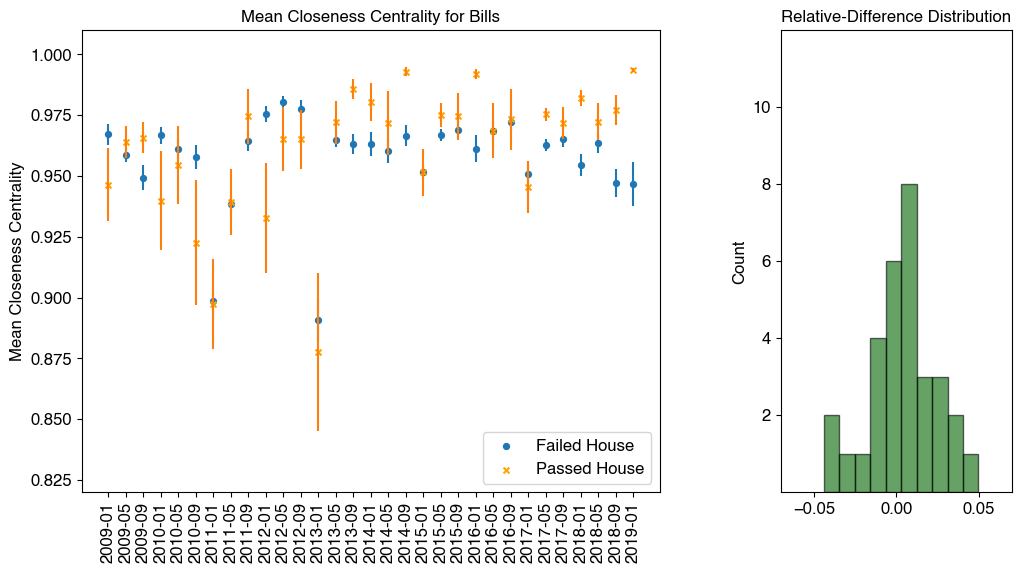

0.003931457616692593

In [137]:
avg_centrality_close = plot_avg_centrality(avg_close_centrality111_115, "Mean Closeness Centrality", "Mean Closeness Centrality for Bills", ax1ylim=[0.82,1.01])
avg_centrality_close["Percent_Difference"].mean()

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/3007802054.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize


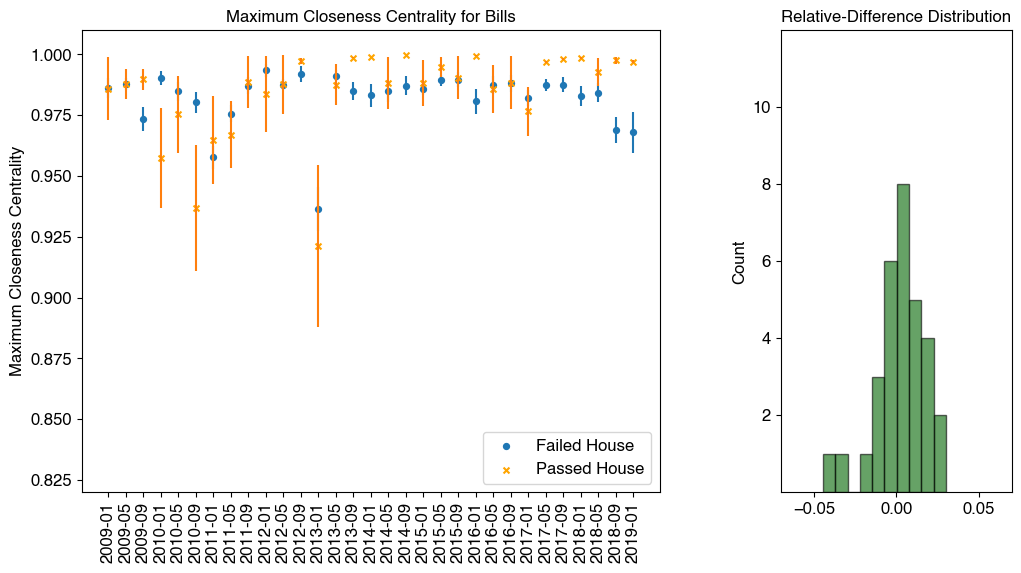

0.002489076858511547

In [138]:
avg_centrality_max = plot_max_centrality(max_close_centrality111_115, "Maximum Closeness Centrality", "Maximum Closeness Centrality for Bills", ax1ylim=[0.82,1.01])
avg_centrality_max["Percent_Difference"].mean()

## Degree Centrality

In [139]:
if Path("./pickles/DegreeCentrality.npy").exists():
	with open("./pickles/DegreeCentrality.npy", "rb") as f:
		avg_dg_centrality111_115 = pickle.load(f)
		max_dg_centrality111_115 = pickle.load(f)
else:
	house_care=["PASS_OVER:HOUSE", "ENACTED:SIGNED", "PASS_BACK:SENATE", "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE", "PROV_KILL:CLOTUREFAILED", "PROV_KILL:VETO", "ENACTED:TENDAYRULE", "CONFERENCE:PASSED:HOUSE"]

	dataMatrix_dg=build_dg_centrality_scores(housefail_cham_congress111)
	dg_avg_centrality111=build_avg_centrality_df(111,"2009-01", dataMatrix_dg, "house", house_care)
	dg_max_centrality111=build_max_centrality_df(111,"2009-01", dataMatrix_dg, "house", house_care)

	dataMatrix_dg=build_dg_centrality_scores(housefail_cham_congress112)
	dg_avg_centrality112=build_avg_centrality_df(112,"2011-01", dataMatrix_dg, "house", house_care)
	dg_max_centrality112=build_max_centrality_df(112,"2011-01", dataMatrix_dg, "house", house_care)

	dataMatrix_dg=build_dg_centrality_scores(housefail_cham_congress113)
	dg_avg_centrality113=build_avg_centrality_df(113,"2013-01", dataMatrix_dg, "house", house_care)
	dg_max_centrality113=build_max_centrality_df(113,"2013-01", dataMatrix_dg, "house", house_care)

	dataMatrix_dg=build_dg_centrality_scores(housefail_cham_congress114)
	dg_avg_centrality114=build_avg_centrality_df(114,"2015-01", dataMatrix_dg, "house", house_care)
	dg_max_centrality114=build_max_centrality_df(114,"2015-01", dataMatrix_dg, "house", house_care)

	dataMatrix_dg=build_dg_centrality_scores(housefail_cham_congress115)
	dg_avg_centrality115=build_avg_centrality_df(115,"2017-01", dataMatrix_dg, "house", house_care)
	dg_max_centrality115=build_max_centrality_df(115,"2017-01", dataMatrix_dg, "house", house_care)

	avg_dg_centrality111_115=pd.concat([dg_avg_centrality111, dg_avg_centrality112, dg_avg_centrality113, dg_avg_centrality114, dg_avg_centrality115])
	max_dg_centrality111_115=pd.concat([dg_max_centrality111, dg_max_centrality112, dg_max_centrality113, dg_max_centrality114, dg_max_centrality115])

	with open("./pickles/DegreeCentrality.npy", "wb") as f:
		avg_dg_centrality111_115.to_pickle(f)
		max_dg_centrality111_115.to_pickle(f)

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/3846369664.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize


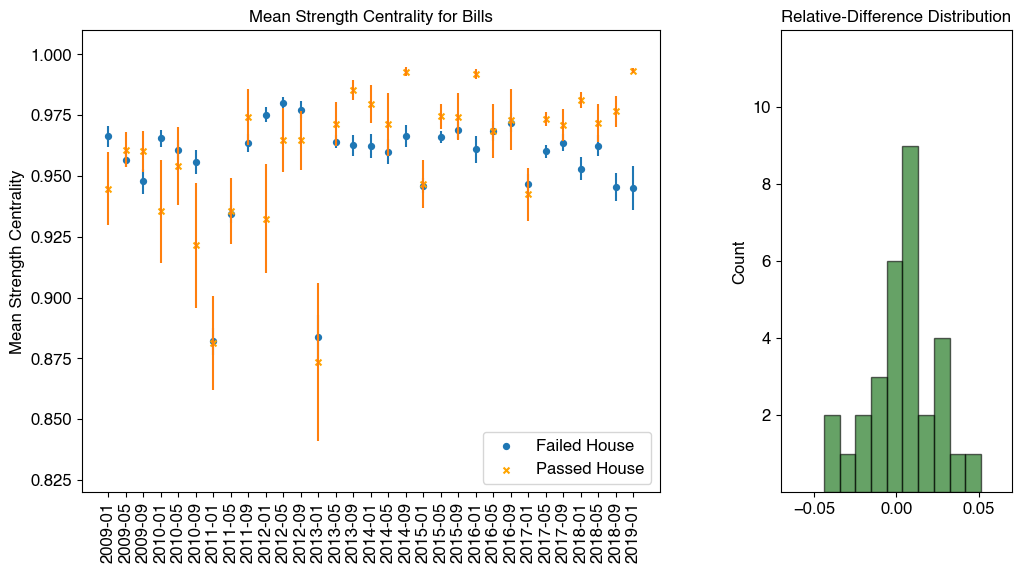

0.004056710142877931

In [140]:
avg_centrality_per = plot_avg_centrality(avg_dg_centrality111_115,"Mean Strength Centrality", "Mean Strength Centrality for Bills", ax1ylim=[0.82,1.01])
avg_centrality_per["Percent_Difference"].mean()

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/3007802054.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize


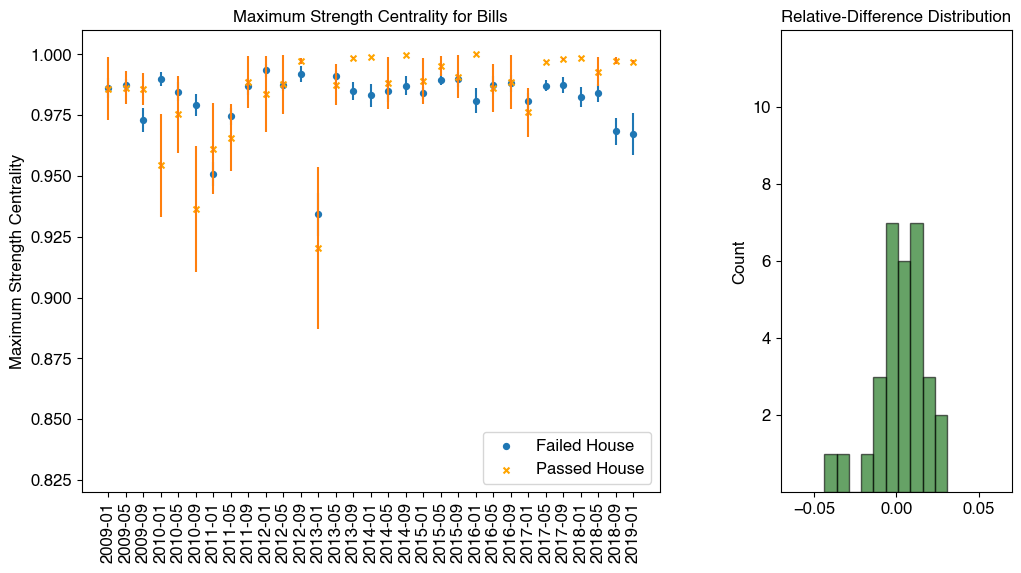

0.0026807883702748996

In [141]:
max_centrality_per = plot_max_centrality(max_dg_centrality111_115,"Maximum Strength Centrality", "Maximum Strength Centrality for Bills", ax1ylim=[0.82,1.01])
max_centrality_per["Percent_Difference"].mean()

## Eigenvector Centrality

In [142]:
if Path("./pickles/EigenvectorCentrality.npy").exists():
	with open('./pickles/EigenvectorCentrality.npy', 'rb') as fd:
		avg_ev_centrality111_115 = pickle.load(fd)
		max_ev_centrality111_115 = pickle.load(fd)
else:
	house_care=["PASS_OVER:HOUSE", "ENACTED:SIGNED", "PASS_BACK:SENATE", "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE", "PROV_KILL:CLOTUREFAILED", "PROV_KILL:VETO", "ENACTED:TENDAYRULE", "CONFERENCE:PASSED:HOUSE"]

	dataMatrix_ev=build_ev_centrality_scores(housefail_cham_congress111)
	ev_avg_centrality111=build_avg_centrality_df(111,"2009-01", dataMatrix_ev, "house", house_care)
	ev_max_centrality111=build_max_centrality_df(111,"2009-01", dataMatrix_ev, "house", house_care)

	dataMatrix_ev=build_ev_centrality_scores(housefail_cham_congress112)
	ev_avg_centrality112=build_avg_centrality_df(112,"2011-01", dataMatrix_ev, "house", house_care)
	ev_max_centrality112=build_max_centrality_df(112,"2011-01", dataMatrix_ev, "house", house_care)

	dataMatrix_ev=build_ev_centrality_scores(housefail_cham_congress113)
	ev_avg_centrality113=build_avg_centrality_df(113,"2013-01", dataMatrix_ev, "house", house_care)
	ev_max_centrality113=build_max_centrality_df(113,"2013-01", dataMatrix_ev, "house", house_care)

	dataMatrix_ev=build_ev_centrality_scores(housefail_cham_congress114)
	ev_avg_centrality114=build_avg_centrality_df(114,"2015-01", dataMatrix_ev, "house", house_care)
	ev_max_centrality114=build_max_centrality_df(114,"2015-01", dataMatrix_ev, "house", house_care)

	dataMatrix_ev=build_ev_centrality_scores(housefail_cham_congress115)
	ev_avg_centrality115=build_avg_centrality_df(115,"2017-01", dataMatrix_ev, "house", house_care)
	ev_max_centrality115=build_max_centrality_df(115,"2017-01", dataMatrix_ev, "house", house_care)

	avg_ev_centrality111_115=pd.concat([ev_avg_centrality111, ev_avg_centrality112, ev_avg_centrality113, ev_avg_centrality114, ev_avg_centrality115])
	max_ev_centrality111_115=pd.concat([ev_max_centrality111, ev_max_centrality112, ev_max_centrality113, ev_max_centrality114, ev_max_centrality115])

	with open("./pickles/EigenvectorCentrality.npy", "wb") as f:
		avg_ev_centrality111_115.to_pickle(f)
		max_ev_centrality111_115.to_pickle(f)

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/3846369664.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize


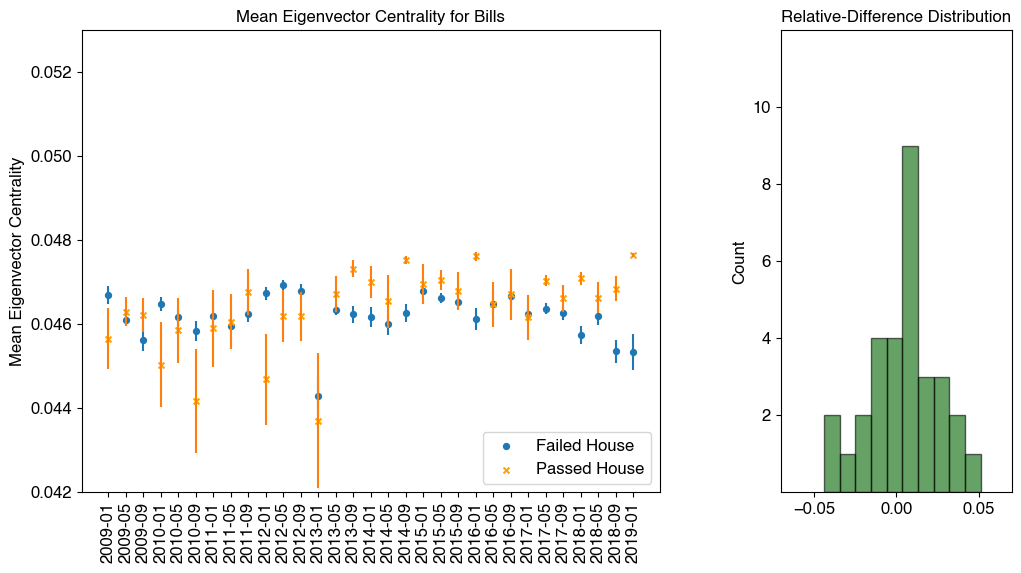

0.0040875316350581425

In [143]:
avg_centrality_per = plot_avg_centrality(avg_ev_centrality111_115,"Mean Eigenvector Centrality", "Mean Eigenvector Centrality for Bills", ax1ylim=[0.042,0.053])
avg_centrality_per["Percent_Difference"].mean()

/var/folders/ym/ph5q_6vn3fl5hj4x_hngrf_w0000gn/T/ipykernel_81364/3007802054.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=12)	# Set x-axis tick labels with rotation and fontsize


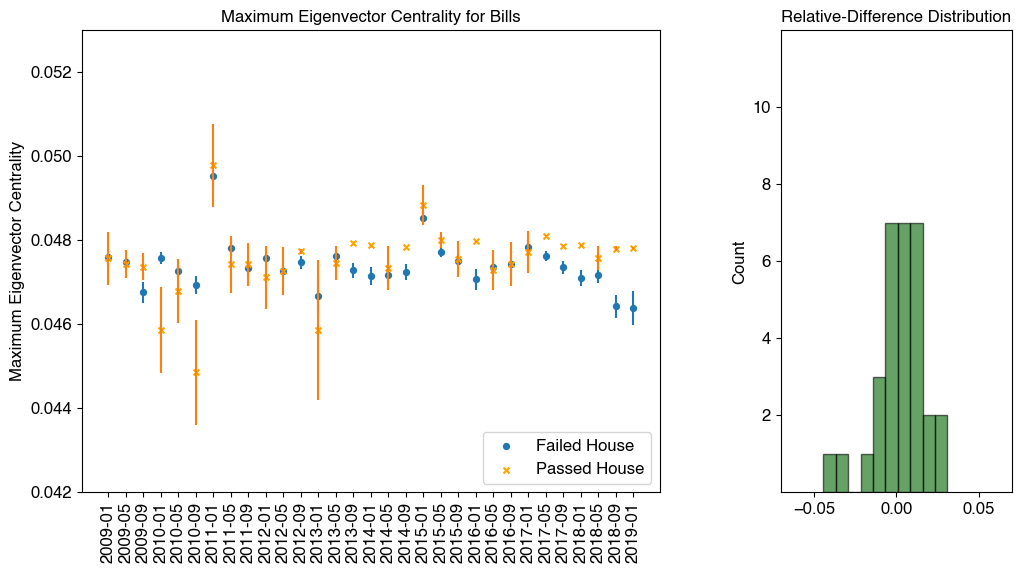

0.002455312193526344

In [144]:
max_centrality_per = plot_max_centrality(max_ev_centrality111_115,"Maximum Eigenvector Centrality","Maximum Eigenvector Centrality for Bills", ax1ylim=[0.042,0.053])
max_centrality_per["Percent_Difference"].mean()

## 111-115 Congress, Fail Chamber House

6 Half-life

In [145]:
# house_care=["PASS_OVER:HOUSE", "ENACTED:SIGNED", "PASS_BACK:SENATE", "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE", "PROV_KILL:CLOTUREFAILED", "PROV_KILL:VETO", "ENACTED:TENDAYRULE", "CONFERENCE:PASSED:HOUSE"]
# adj_fail_house=build_co_adj_matrix(carelist=house_care, chamber="house")
# cum_adj_fail_house_6hl=create_cumulative_adj_matrix(adj_fail_house, half_life=6)
# cum_adj_fail_house_6hl=cum_adj_fail_house_6hl[:120,:,:,:]

In [146]:
# party_fail_house_6hl=create_party_inf_matrix(cum_adj_fail_house_6hl, "house")
# party_fail_house_6hl_total = np.sum(party_fail_house_6hl, axis=-1)

# fail_house_avg_bill_6h=influence_by_bill("2009-01", party_fail_house_6hl_total, "house", house_care, normalize_cosponsor=True)
# fail_house_max_bill_6h=max_influence_by_bill("2009-01", party_fail_house_6hl_total, "house", house_care)

In [147]:
# with open("./pickles/FailHouse6HalfLife.npy", "wb") as f:
#	 np.save(f, cum_adj_fail_house_6hl, allow_pickle=True)
#	 np.save(f, party_fail_house_6hl_total, allow_pickle=True)
#	 fail_house_avg_bill_6h.to_pickle(f)	#average
#	 fail_house_max_bill_6h.to_pickle(f)

12 Half-life

In [148]:
# house_care=["PASS_OVER:HOUSE", "ENACTED:SIGNED", "PASS_BACK:SENATE", "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE", "PROV_KILL:CLOTUREFAILED", "PROV_KILL:VETO", "ENACTED:TENDAYRULE", "CONFERENCE:PASSED:HOUSE"]
# adj_fail_house=build_co_adj_matrix(carelist=house_care, chamber="house")
# cum_adj_fail_house_12hl=create_cumulative_adj_matrix(adj_fail_house, half_life=12)
# cum_adj_fail_house_12hl=cum_adj_fail_house_12hl[:120,:,:,:]

In [149]:
# party_fail_house_12hl=create_party_inf_matrix(cum_adj_fail_house_12hl, "house")
# party_fail_house_12hl_total = np.sum(party_fail_house_12hl, axis=-1)

# fail_house_avg_bill_12h=influence_by_bill("2009-01", party_fail_house_12hl_total, "house", house_care, normalize_cosponsor=True)
# fail_house_max_bill_12h=max_influence_by_bill("2009-01", party_fail_house_12hl_total, "house", house_care)

In [150]:
# with open("./pickles/FailHouse12HalfLife.npy", "wb") as f:
#	 np.save(f, cum_adj_fail_house_12hl, allow_pickle=True)
#	 np.save(f, party_fail_house_12hl_total, allow_pickle=True)
#	 fail_house_avg_bill_12h.to_pickle(f)	#average
#	 fail_house_max_bill_12h.to_pickle(f)

24 Half-life

In [151]:
# house_care=["PASS_OVER:HOUSE", "ENACTED:SIGNED", "PASS_BACK:SENATE", "VETOED:OVERRIDE_FAIL_ORIGINATING:HOUSE", "PROV_KILL:CLOTUREFAILED", "PROV_KILL:VETO", "ENACTED:TENDAYRULE", "CONFERENCE:PASSED:HOUSE"]
# adj_fail_house=build_co_adj_matrix(carelist=house_care, chamber="house")
# cum_adj_fail_house_24hl=create_cumulative_adj_matrix(adj_fail_house, half_life=24)

In [152]:
# cum_adj_fail_house_24hl=cum_adj_fail_house_24hl[:120,:,:,:]

In [153]:
# party_fail_house_24hl=create_party_inf_matrix(cum_adj_fail_house_24hl, "house")
# party_fail_house_24hl_total = np.sum(party_fail_house_24hl, axis=-1)

# fail_house_avg_bill_24h=influence_by_bill("2009-01", party_fail_house_24hl_total, "house", house_care, normalize_cosponsor=True)
# fail_house_max_bill_24h=max_influence_by_bill("2009-01", party_fail_house_24hl_total, "house", house_care)

In [154]:
# with open("./pickles/FailHouse24HalfLife.npy", "wb") as f:
#	 np.save(f, cum_adj_fail_house_24hl, allow_pickle=True)
#	 np.save(f, party_fail_house_24hl_total, allow_pickle=True)
#	 fail_house_avg_bill_24h.to_pickle(f)	#average
#	 fail_house_max_bill_24h.to_pickle(f)